### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from mne import channels

## Importing 
import pyhsmm_mvpa as hsmm
from pyhsmm_mvpa import simulations

### Simulating data

In [45]:
cpus = 16 # For multiprocessing
path = 'simulated/'

n_events = 60 #Number of trials to simulate

sources = [['lateraloccipital-lh',1e-2, [np.random.gamma,2,15]],#One source = localization, acitvation amplitude and onset latencies
           ['postcentral-lh', 1e-2, [np.random.gamma, 2, 50]],
           ['posteriorcingulate-rh', 1e-2, [np.random.gamma, 2,40]],
           ['postcentral-rh', 1e-2, [np.random.gamma, 2,100]],
           ['postcentral-lh', 1e-10, [np.random.gamma, 2,75]]]#Equivalent to a response trigger as amplitude make it hardly visible

max_trial_length = 3000#length of a trial (ISI)

bump_frequency = 10.#Frequency of the simulated bumps
file = 'dataset_tutorial'
mne_path = path+file+'_raw.fif'

raw, generating_events = simulations.simulate(sources, n_events, max_trial_length, cpus, bump_frequency, file, path, overwrite=True)

Aligning file name to MNE's convention
Simulating dataset_tutorial_raw.fif in simulated/
Overwriting existing file.
Writing /home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/simulated/dataset_tutorial_raw.fif
Closing /home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/simulated/dataset_tutorial_raw.fif
[done]
simulated/dataset_tutorial_raw.fif simulated


### Creating the event structure and plotting the raw data

In [46]:
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':0}
resp_id = {'response':resp_trigger}
events = generating_events[(generating_events[:,2] == 0) | (generating_events[:,2] == resp_trigger)]

%matplotlib qt
raw.copy().pick_types(eeg=True).plot(scalings=dict(eeg=10), events=events);

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Opening raw-browser...


### Recovering number of sources as well as actual by-trial variation

Closing raw-browser...
Channels marked as bad:
none


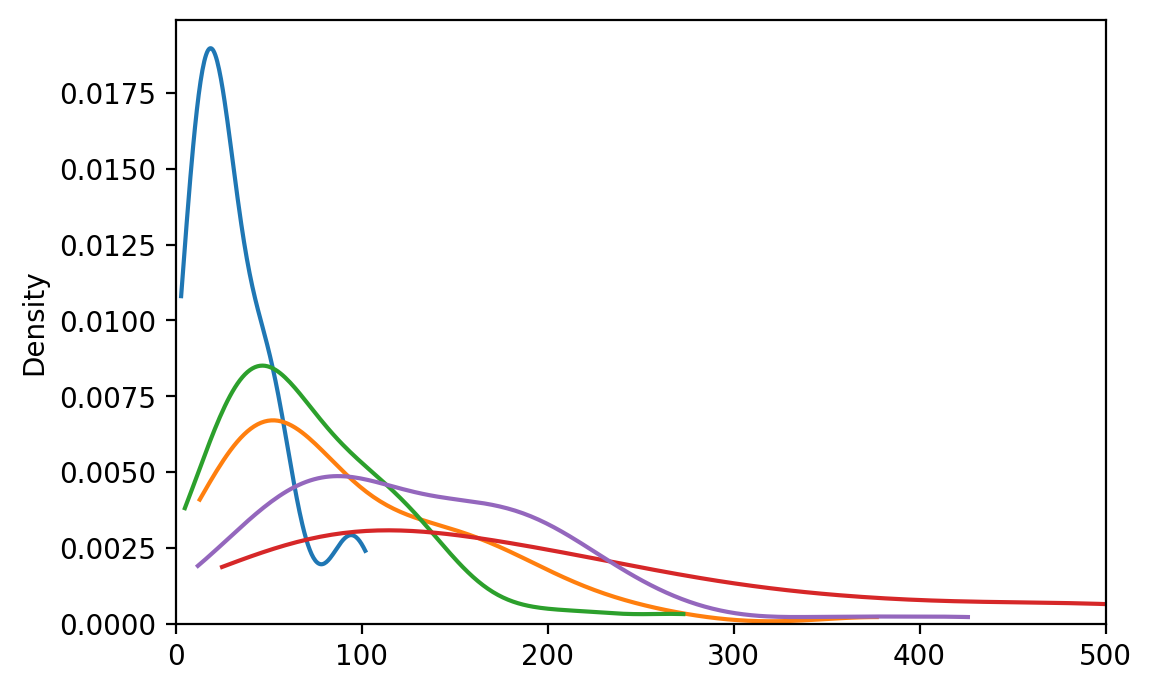

In [47]:
%matplotlib inline
number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

i,x = 1,0                  
while x < len(random_source_times):
    for j in np.arange(number_of_sources):#recovering the individual duration- of bump onset
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

plt.figure(dpi=200)
for source in random_source_times.T:#plotting these source durations
    sns.kdeplot(source, cut=0)
plt.xlim(0,500)
plt.show()

## Demo of the HsMM Code for a single participant in a single condition based on the simulated data

In [64]:
# Reading the data
eeg_dat = hsmm.utils.read_mne_EEG(mne_path, event_id, resp_id, raw.info['sfreq'],events, verbose=False)


Processing participant simulated/dataset_tutorial_raw.fif
Reading 0 ... 194999  =      0.000 ...   324.666 secs...
N trials without response event: 0
Applying reaction time trim to keep RTs between 0.001 and 5 seconds
60 trials were retained for participant simulated/dataset_tutorial_raw.fif


In [65]:
raw.info['sfreq']

600.614990234375

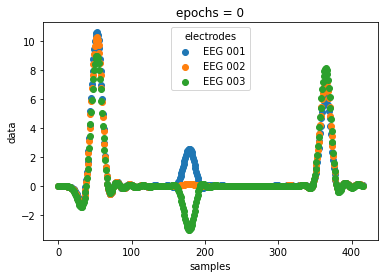

In [66]:
#example of usage of xarray
eeg_dat.sel(epochs=0,electrodes=['EEG 001','EEG 002','EEG 003']).plot.scatter(x='samples', y='data',hue='electrodes')

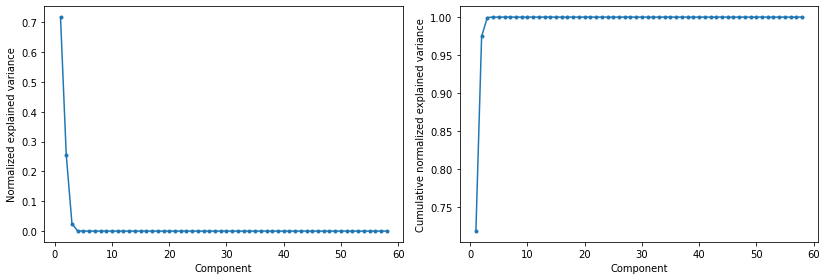

How many PCs (80 and 95% explained variance at component n2 and n2)? 10


In [67]:
hsmm_dat, PCs, explained_var, means = hsmm.utils.transform_data(eeg_dat.data,'',
        apply_standard=False, single=True)

hsmm_dat = hsmm.utils.stack_data(hsmm_dat,'',single=True)

In [68]:
hsmm_dat

<xarray.Dataset>
Dimensions:      (component: 10, all_samples: 32477, participant: 1, trial: 60)
Coordinates:
  * component    (component) int64 0 1 2 3 4 5 6 7 8 9
  * all_samples  (all_samples) object MultiIndex
  * epochs       (all_samples) int64 0 0 0 0 0 0 0 0 ... 59 59 59 59 59 59 59 59
  * samples      (all_samples) int64 0 1 2 3 4 5 6 ... 483 484 485 486 487 488
  * trial        (trial) int64 0 1 2 3 4 5 6 7 8 ... 51 52 53 54 55 56 57 58 59
Dimensions without coordinates: participant
Data variables:
    data         (participant, component, all_samples) float64 -0.2994 ... -0...
    starts       (trial) int64 0 416 778 1877 2216 ... 30303 30662 31291 31988
    ends         (trial) int64 415 777 1876 2215 ... 30661 31290 31987 32476

# Estimating a 4 bump model

In [69]:
init = hsmm.models.hsmm(hsmm_dat.data.T[:,:,0], hsmm_dat.starts.data, 
                 hsmm_dat.ends.data, sf=eeg_dat.sfreq, bump_width=50, cpus=16)

estimates = init.fit_single(number_of_sources-1)

Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model


### Visualizing results of the fit

In [70]:
selected = estimates
bump_times_selected = init.bump_times(selected.eventprobs)
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes_selected = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)

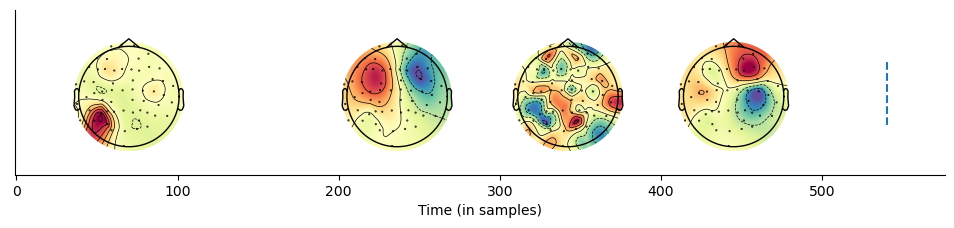

In [71]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

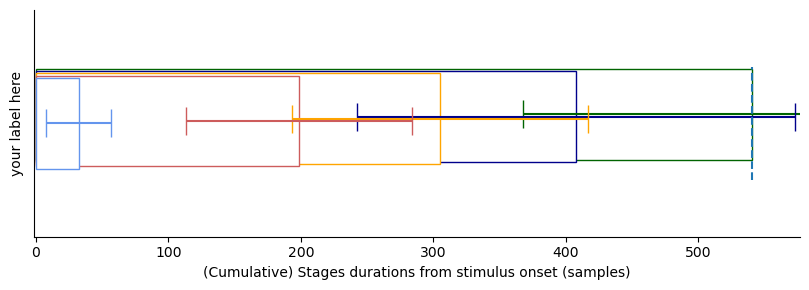

In [72]:
ax = hsmm.visu.plot_latencies_average(bump_times_selected, init.bump_width_samples, 1, errs='std', times_to_display = np.mean(init.ends - init.starts))
ax.set_ylabel('your label here');

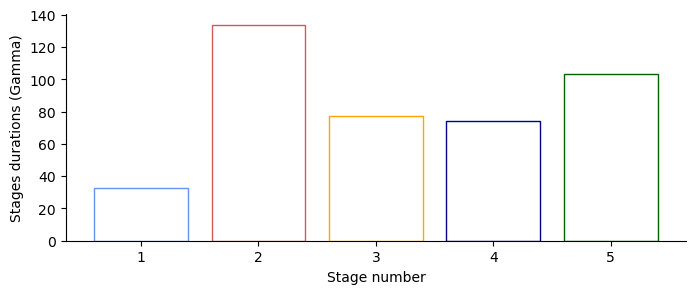

In [73]:
hsmm.visu.plot_latencies_gamma(selected.parameters.dropna('stage').values, init.bump_width_samples,  times_to_display = np.mean(init.ends - init.starts));

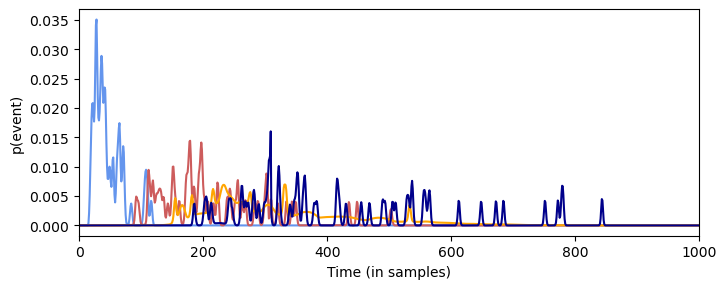

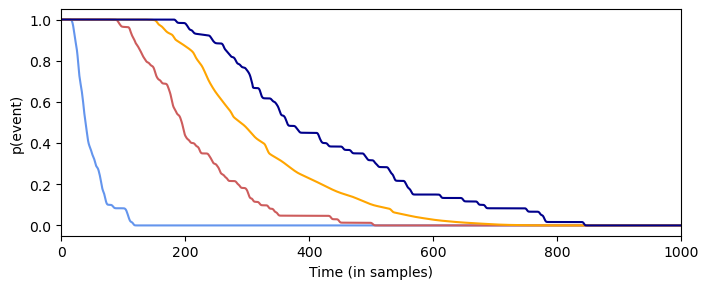

In [74]:
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial']), xlims=(0,1000))
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial']), xlims=(0,1000), survival=True);

## Comparing with ground truth

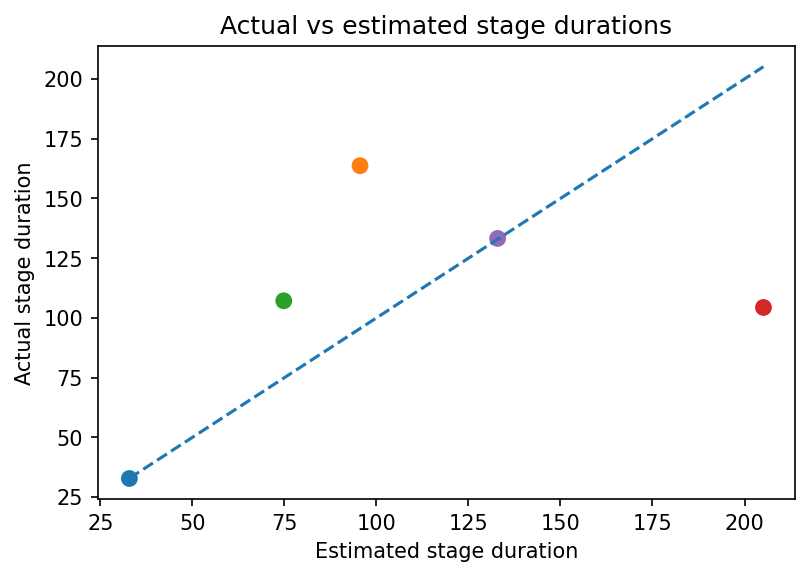

In [75]:
plt.figure(dpi=150)
colors = sns.color_palette(None, number_of_sources)#['darkblue','indianred','darkgreen','red','purple','grey']
#print(np.mean(random_source_times, axis=0)- (estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)])))
plt.scatter(np.mean(random_source_times, axis=0), estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()


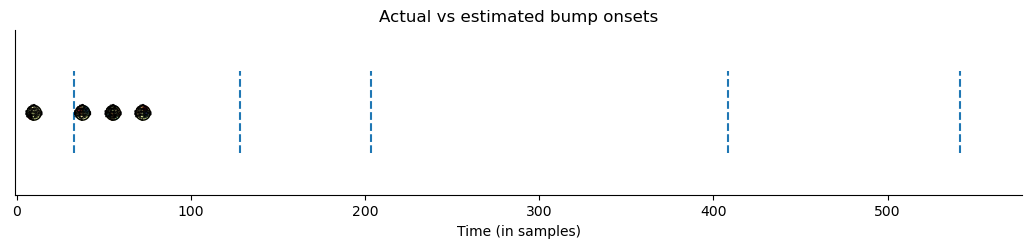

In [62]:
positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.utils.reconstruct(estimates.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, np.mean(init.bump_times(estimates.eventprobs), axis=0), positions,#inferring electrode location, 
        bump_size=init.bump_width_samples, time_step = 1, magnify=4, figsize=(13,2), title='Actual vs estimated bump onsets',
        times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

In [ ]:

fig, ax= plt.subplots(number_of_sources-1,1, figsize=(5,3.5*number_of_sources))
ax[0].set_title('Comparing true vs estimated single trial stage durations')
i = 0
gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
for bump in init.bump_times(estimates.eventprobs)[:,:number_of_sources-1].T:
    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
    i+= 1

# N_bump selection: iterative backward estimates

In [76]:
bests = init.backward_estimation()

bests

Estimating all solutions for maximal number of bumps (8) with 0 random starting points
Estimating parameters for 8 bumps model
Parameters estimated for 8 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 1099, trial: 60)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 1.537e+03 1.789e+03 ... 1.178e+03 401.9
    parameters   (n_bumps, stage, params) float64 2.0 16.02 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -1.035 4.289 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

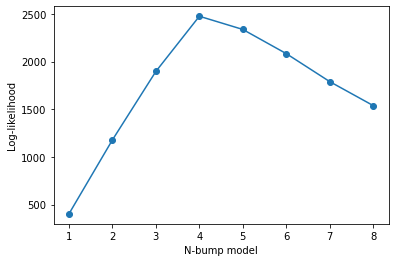

In [77]:
plt.plot(np.arange(init.max_bumps,0,-1), bests.likelihoods,'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-bump model')
plt.show()

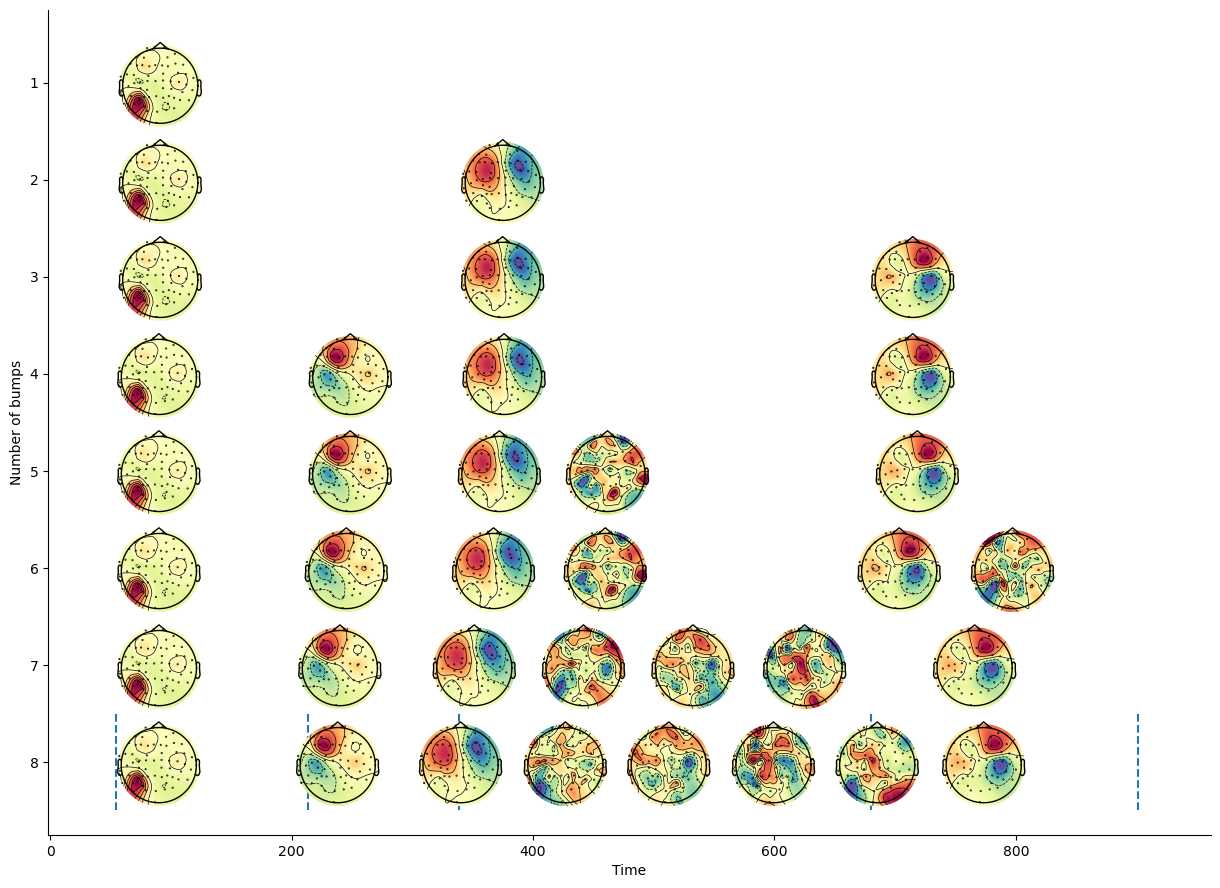

In [78]:
electrodes = hsmm.utils.reconstruct(bests.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init.bump_times(x),axis=0) for x in bests.eventprobs], positions,
    bump_size=init.bump_width_samples, time_step = 1000/init.sf,  magnify=3, times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0),
    figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})

In [79]:
selected = bests.sel(n_bumps=4)
bump_times_selected = init.bump_times(selected.eventprobs.dropna('bump'))
mean_bump_times_selected = np.mean(bump_times_selected, axis=0)
electrodes_selected = xr.DataArray(hsmm.utils.reconstruct(selected.magnitudes,PCs, explained_var, means))

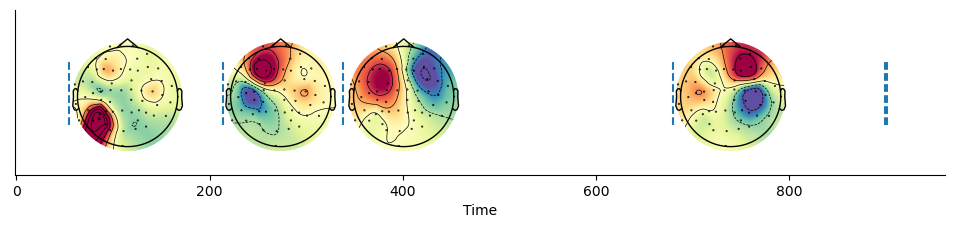

In [80]:
hsmm.visu.plot_topo_timecourse(electrodes_selected, mean_bump_times_selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2),
                                time_step = 1000/init.sf,  times_to_display = np.concatenate([np.mean(np.cumsum(random_source_times,axis=1),axis=0),[np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data)]]),
                                ylabels='5 bumps model', vmin=-10, vmax=10)

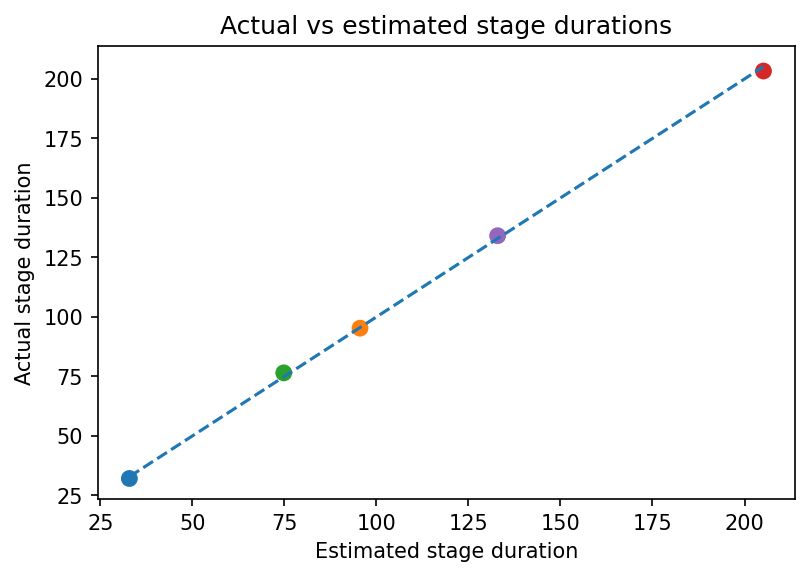

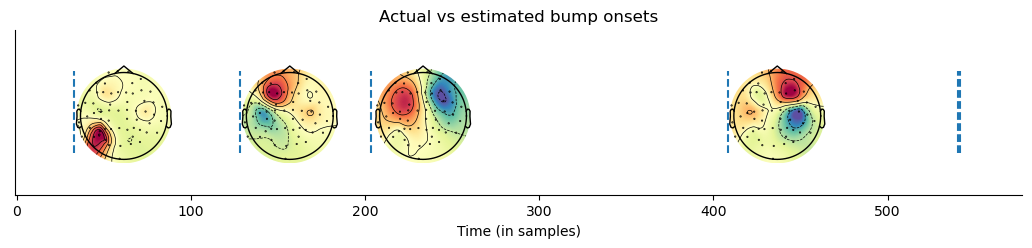

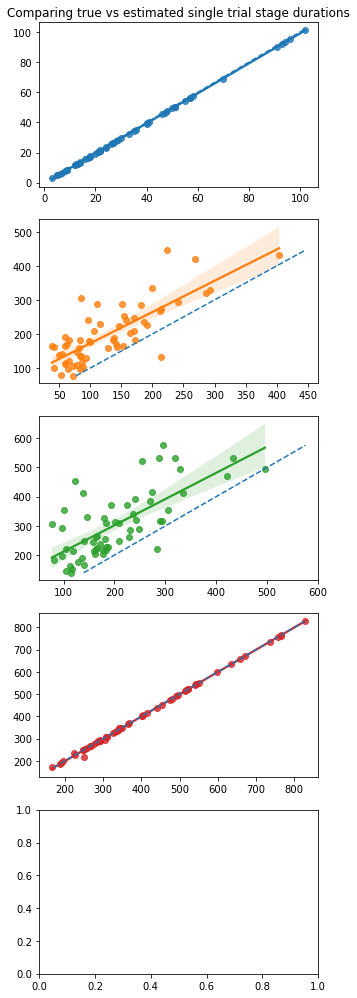

In [82]:
plt.figure(dpi=150)
colors = sns.color_palette(None, number_of_sources)#['darkblue','indianred','darkgreen','red','purple','grey']
#print(np.mean(random_source_times, axis=0)- (estimates.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)])))
plt.scatter(np.mean(random_source_times, axis=0), selected.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()

positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location
electrodes = hsmm.utils.reconstruct(selected.magnitudes, PCs, explained_var, means)

hsmm.visu.plot_topo_timecourse(electrodes, np.mean(init.bump_times(selected.eventprobs), axis=0), positions,#inferring electrode location, 
        bump_size=init.bump_width_samples, time_step = 1, magnify=4, figsize=(13,2), title='Actual vs estimated bump onsets',
        times_to_display = np.concatenate([np.mean(np.cumsum(random_source_times,axis=1),axis=0),[np.mean(hsmm_dat.ends.data - hsmm_dat.starts.data)]]))

fig, ax= plt.subplots(5,1, figsize=(5,3.5*number_of_sources))
ax[0].set_title('Comparing true vs estimated single trial stage durations')
i = 0
gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
for bump in init.bump_times(estimates.eventprobs)[:,:number_of_sources-1].T:
    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
    i+= 1